In [227]:
import os
import sys
import emcee
import radvel
import corner
import george

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from george import kernels
import scipy.optimize as optimize

from scipy.optimize import minimize, Bounds
from scipy.stats import uniform, reciprocal

# Calculate the path to the src directory
src_dir = os.path.join(os.path.dirname(os.getcwd()), 'src')
sys.path.append(src_dir)

# Now you can import your modules
from config_loader import load_config  # Assuming load_config is a function in config_loader
from data_pipeline import clean_data

The first approach is similar to the one used by C19. We fitted the
RV data using Keplerians for the planetary signals and a GP with
a quasi-periodic kernel for the stellar activity. The mathematical
expression of the kernel of this GP is

$$
GP(t_i, t_j) = \eta_1^2 exp[-\frac{|t_i-t_j|^2}{\eta_2^2} -\frac{sin^2(\pi|t_i-t_j|/\eta_3)}{2\eta_4^2}] 
$$

$$
\eta_1 = \text{amplitude of the covariance; Arv}
$$
$$
\eta_2 = \text{decay timescale; } \tau_{\text{decay}}
$$
$$
\eta_3 = \text{period of recurrence of the covariance; } P_{\text{rot}}
$$
$$
\eta_4 = \text{periodic coherence scale; } \gamma
$$


where Arv is the amplitude of the covariance, τdecay is the decay timescale, Prot is the period of recurrence of the covariance,
and γ is the periodic coherence scale (e.g., Grunblatt et al. 2015).
We used the Python package george

In [2]:
# Load the config file
config = load_config('../config.ini')

# Data paths
espresso_path = config['Paths']['espresso']
harps_path = config['Paths']['harps']

# Clean the data
combined_df,\
harps_df,\
cleaned_harps_df,\
espresso_df,\
cleaned_espresso_df,\
cleaned_pre_df,\
cleaned_post_df = clean_data(espresso_path, harps_path)

In [30]:
combined_df.head()

,Time,RV,e_RV,FWHM,e_FWHM,BIS,e_BIS,Contrast,e_Contrast,Sindex,...,Halpha,e_Halpha,NaD,e_NaD,BERV,Inst,Hbeta,e_Hbeta,Hgamma,e_Hgamma
0,2.458437e+06,-5573.437416,0.816913,4499.263409,1.633825,20.033978,1.633825,42.799587,0.015542,0.598479,...,0.600940,0.000142,0.067823,0.000083,3.416847,Pre,NaN,NaN,NaN,NaN
1,2.458445e+06,-5576.693982,0.793815,4498.810086,1.587631,19.357431,1.587631,42.597043,0.015033,0.688857,...,0.596644,0.000139,0.073309,0.000082,4.175202,Pre,NaN,NaN,NaN,NaN
2,2.458464e+06,-5580.193552,0.653161,4507.480887,1.306323,20.52243,1.306323,42.765184,0.012394,0.672483,...,0.600782,0.000109,0.064390,0.000062,5.718515,Pre,NaN,NaN,NaN,NaN
3,2.458471e+06,-5579.244790,0.676495,4503.037787,1.352990,16.917991,1.352990,42.717744,0.012835,0.613767,...,0.616538,0.000113,0.061649,0.000064,6.179283,Pre,NaN,NaN,NaN,NaN
4,2.458489e+06,-5578.568851,1.060688,4510.972651,2.121377,22.321148,2.121377,42.689840,0.020076,0.714336,...,0.602749,0.000190,0.068562,0.000113,6.850254,Pre,NaN,NaN,NaN,NaN


In [70]:
time_pre = cleaned_pre_df['Time']
time_post = cleaned_post_df['Time']
time_harps = cleaned_harps_df['Time']

rv_pre = cleaned_pre_df['RV']
rv_post = cleaned_post_df['RV']
rv_harps = cleaned_harps_df['RV']

e_rv_pre = cleaned_pre_df['e_RV']
e_rv_post = cleaned_post_df['e_RV']
e_rv_harps = cleaned_harps_df['e_RV']

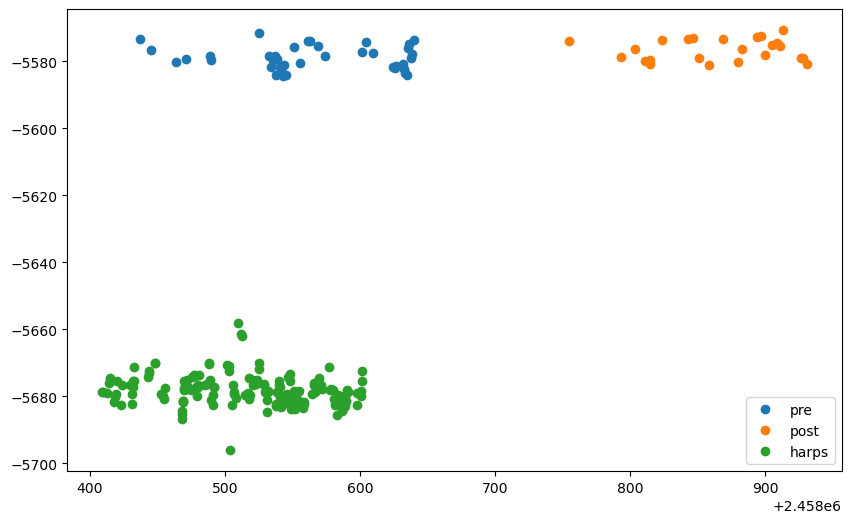

In [32]:
# quick plot
plt.figure(figsize=(10, 6))
plt.plot(cleaned_pre_df['Time'], cleaned_pre_df['RV'], 'o', label='pre')
plt.plot(cleaned_post_df['Time'], cleaned_post_df['RV'], 'o', label='post')
plt.plot(harps_df['Time'], harps_df['RV'], 'o', label='harps')
plt.legend()

# Instrumental Model

## Offset term priors

ESPRESSOpre as RV reference, meaning that v0 was measured with the data coming from this instrument. 

Model the RV
offsets with the other two instruments with two offset parameters
$∆RV_{HARPS/pre}$ and $∆RV_{post/pre}$.

And then a jitter term for each instrument.


I will set these up with priors as follows

Prior PDF of the offsets between the RV instruments (∆RVHARPS {pre, ∆RVpost{pre) are
Gaussian distributions with means equal to the difference of the
median values of the data sets and variances equal to the sum
of their variances.

And the prior PDF of the additive jitter parameters  are uniform distributions between zero and five
times the median values of the reported error bars for each data
se

In [75]:
## Instrumental model priors for RV instrumental offset

# mean = difference in median values of data
# variance = sum of variances
rv_harps = cleaned_harps_df['RV'].copy()
rv_pre = cleaned_pre_df['RV'].copy()    # Reference
rv_post = cleaned_post_df['RV'].copy()

# median values
median_harps = np.median(rv_harps)
median_pre = np.median(rv_pre)
median_post = np.median(rv_post)

# variances
var_harps = np.var(rv_harps, ddof=1)
var_pre = np.var(rv_pre, ddof=1)
var_post = np.var(rv_post, ddof=1)

# offset mean
rv_offset_mean_harps_pre = median_harps - median_pre    # -99.35521000000062
rv_offset_mean_post_pre = median_post - median_pre    # 2.8595649999997477

# offset variance
rv_offset_var_harps_pre = np.sqrt(var_harps + var_pre)  # 4.911649037727071
rv_offset_var_post_pre = np.sqrt(var_post + var_pre)    # 4.654121588541066

# v0
v0_mean = median_pre
v0_variance = var_pre

print(rv_offset_mean_harps_pre, rv_offset_var_harps_pre)
print(rv_offset_mean_post_pre, rv_offset_var_post_pre)
print(v0_mean, np.sqrt(v0_variance))

'''# corrected RVs
rv_harps_corrected = rv_harps - rv_offset_mean_harps_pre
rv_post_corrected = rv_post - rv_offset_mean_post_pre

# Update the original DataFrames directly
cleaned_harps_df.loc[:, 'RV'] = rv_harps_corrected
cleaned_post_df.loc[:, 'RV'] = rv_post_corrected

# quick plot
plt.figure(figsize=(10, 6))
plt.plot(cleaned_pre_df['Time'], cleaned_pre_df['RV'], 'o', label='pre')
plt.plot(cleaned_post_df['Time'], cleaned_post_df['RV'], 'o', label='post')
plt.plot(cleaned_harps_df['Time'], cleaned_harps_df['RV'], 'o', label='harps')
plt.legend()

# Merge the adjusted data
combined_adjusted_df = pd.concat([cleaned_pre_df, cleaned_post_df, cleaned_harps_df], ignore_index=True)'''



-99.35521000000062 4.950649297120366
2.8595649999997477 4.733139014084523
-5579.24479 3.4584860369889427


"# corrected RVs\nrv_harps_corrected = rv_harps - rv_offset_mean_harps_pre\nrv_post_corrected = rv_post - rv_offset_mean_post_pre\n\n# Update the original DataFrames directly\ncleaned_harps_df.loc[:, 'RV'] = rv_harps_corrected\ncleaned_post_df.loc[:, 'RV'] = rv_post_corrected\n\n# quick plot\nplt.figure(figsize=(10, 6))\nplt.plot(cleaned_pre_df['Time'], cleaned_pre_df['RV'], 'o', label='pre')\nplt.plot(cleaned_post_df['Time'], cleaned_post_df['RV'], 'o', label='post')\nplt.plot(cleaned_harps_df['Time'], cleaned_harps_df['RV'], 'o', label='harps')\nplt.legend()\n\n# Merge the adjusted data\ncombined_adjusted_df = pd.concat([cleaned_pre_df, cleaned_post_df, cleaned_harps_df], ignore_index=True)"

## Jitter term priors

The prior PDF of the additive jitter parameters  are uniform distributions between zero and five
times the median values of the reported error bars for each data
set.

In [69]:
# error bars for RVs
rv_harps_err = cleaned_harps_df['e_RV']
rv_pre_err = cleaned_pre_df['e_RV']
rv_post_err = cleaned_post_df['e_RV']

# median values
median_harps_err = np.median(rv_harps_err)
median_pre_err = np.median(rv_pre_err)
median_post_err = np.median(rv_post_err)

# five tims the median value
rv_harps_err_max = 5 * median_harps_err
rv_pre_err_max = 5 * median_pre_err
rv_post_err_max = 5 * median_post_err

print(rv_pre_err_max, rv_post_err_max, rv_harps_err_max)

3.97059 3.2853200000000005 10.5


# RV Model

### Data Preperation

In [320]:
# Data preparation
time_pre, rv_pre, e_rv_pre = cleaned_pre_df['Time'].values, cleaned_pre_df['RV'].values, cleaned_pre_df['e_RV'].values
time_post, rv_post, e_rv_post = cleaned_post_df['Time'].values, cleaned_post_df['RV'].values, cleaned_post_df['e_RV'].values
time_harps, rv_harps, e_rv_harps = cleaned_harps_df['Time'].values, cleaned_harps_df['RV'].values, cleaned_harps_df['e_RV'].values


### Function Definitions

In [321]:
# Define the kernel using parameter values that will be sampled by MCMC
def create_kernel(A_RV, P_rot, tau_decay, gamma):
    # Quasi-periodic kernel
    kernel = A_RV**2 * kernels.ExpSine2Kernel(gamma=gamma, log_period=np.log(P_rot)) * kernels.ExpSquaredKernel(metric=tau_decay**2)
    return kernel

# radvel custom functions
def calculate_orbital_phase(tic, tref, period):
    return ((tic - tref) / period) % 1

# radvel custom priors
def beta_prior(value, alpha, beta):
    return stats.beta.logpdf(value, alpha, beta)

def uniform_prior(value, lower, upper):
    return stats.uniform.logpdf(value, lower, upper)

### Stellar Activity Model

In [390]:
def stellar_activity_log_prior(params):
    
    # Unpack the gp hyperparameters
    A_RV, P_rot, tau_decay, gamma = params[:4]

    # Unifrom priors; A_RV, gamma
    prior_A_RV = stats.uniform.logpdf(A_RV, 0, 17)  # U(0, 17)
    prior_gamma = stats.uniform.logpdf(gamma, 0.05, 5)  # U(0.05, 5)

    # P_rot, tau_decay; Additonal logic
    if not (5 <= P_rot <= 520 and 2.5 <= tau_decay <= 2600):
        return -np.inf
    if tau_decay < P_rot / 2:
        return -np.inf  
    
    # Jeffery's prior; P_rot, tau_decay
    prior_P_rot = -np.log(P_rot)    # J(5, 520)
    prior_tau_decay = -np.log(tau_decay)    # J(2.5, 2600)
    
    return prior_A_RV + prior_P_rot + prior_tau_decay + prior_gamma

def stellar_activity_log_likelihood(gp, instrumental_offset, *args):
        
    # Unpack the instrumental offset
    rv_pre_adjusted, rv_post_adjusted, rv_harps_adjusted, err_pre, err_post, err_harps = instrumental_offset

    # Unpack the rv data
    time_pre, _, _, time_post, _, _, time_harps, _, _ = args

    # Compute the ll for each instrument GP
    gp.compute(time_pre, err_pre)
    ll_pre = gp.log_likelihood(rv_pre_adjusted)
    gp.compute(time_post, err_post)
    ll_post = gp.log_likelihood(rv_post_adjusted)
    gp.compute(time_harps, err_harps)
    ll_harps = gp.log_likelihood(rv_harps_adjusted)

    return ll_pre + ll_post + ll_harps

### Instrumental Model

In [391]:
def instrumental_log_priors(params):

    # instrumental model hyperparameters
    v0, offset_post_pre, offset_harps_pre, jitter_pre, jitter_post, jitter_harps = params[4:10]

    # Uniform priors
    prior_jitter_pre = stats.uniform.logpdf(jitter_pre, 0, 4.5)  # U(0, 4.5)
    prior_jitter_post = stats.uniform.logpdf(jitter_post, 0, 3.6)  # U(0, 3.6)
    prior_jitter_harps = stats.uniform.logpdf(jitter_harps, 0, 11)  # U(0, 11)

    # Gaussian priors; offset_post_pre, offset_harps_pre
    priors_v0 = stats.norm.logpdf(v0, loc=-5579.1, scale=3.5)  # N(-5579.1, 3.5)
    prior_offset_post_pre = stats.norm.logpdf(offset_post_pre, loc=2.88, scale=4.8) # N(2.88, 4.8)
    prior_offset_harps_pre = stats.norm.logpdf(offset_harps_pre, loc=-99.5, scale=5.0)  # N(-99.5, 5.0)

    return prior_jitter_pre + prior_jitter_post + prior_jitter_harps + priors_v0 + prior_offset_post_pre + prior_offset_harps_pre

def instrumental_offset(params, *args):

    # instrumental model hyperparameters
    v0, offset_post_pre, offset_harps_pre, jitter_pre, jitter_post, jitter_harps = params[4:10]

    _, rv_pre, e_rv_pre, _, rv_post, e_rv_post, _, rv_harps, e_rv_harps = args

    # Jitter and Offsets
    err_pre = np.sqrt(e_rv_pre**2 + jitter_pre**2)
    err_post = np.sqrt(e_rv_post**2 + jitter_post**2)
    err_harps = np.sqrt(e_rv_harps**2 + jitter_harps**2)

    rv_pre_adjusted = rv_pre - v0
    rv_post_adjusted = rv_post - v0 - offset_post_pre
    rv_harps_adjusted = rv_harps - v0 - offset_harps_pre

    return rv_pre_adjusted, rv_post_adjusted, rv_harps_adjusted, err_pre, err_post, err_harps

### Planetary Model

In [401]:
def planetary_log_priors(params):
    
        # Unpack the planetary parameters
        per1, tc1, sescosw1, sesinw1, k1, per2, tc2, sescosw2, sesinw2, k2, per3, tc3, sescosw3, sesinw3, k3 = params[14:]

        # Calculate eccentricity, omega and phase
        e1 = np.sqrt(sescosw1**2 + sesinw1**2)
        e2 = np.sqrt(sescosw2**2 + sesinw2**2)
        e3 = np.sqrt(sescosw3**2 + sesinw3**2)
        omega1 = np.arctan2(sesinw1, sescosw1)
        omega2 = np.arctan2(sesinw2, sescosw2)
        omega3 = np.arctan2(sesinw3, sescosw3)
        phi1 = calculate_orbital_phase(tc1, 0, per1)
        phi2 = calculate_orbital_phase(tc2, 0, per2)
        phi3 = calculate_orbital_phase(tc3, 0, per3)

        # Uniform priors; omega, k, phi
        omega1_prior = stats.uniform.logpdf(omega1, -np.pi, np.pi)  # U(-pi, pi)
        omega2_prior = stats.uniform.logpdf(omega2, -np.pi, np.pi)  # U(-pi, pi)
        omega3_prior = stats.uniform.logpdf(omega3, -np.pi, np.pi)  # U(-pi, pi)
        k1_prior = stats.uniform.logpdf(k1, 0, 17)  # U(0, 17)
        k2_prior = stats.uniform.logpdf(k2, 0, 17)  # U(0, 17)
        k3_prior = stats.uniform.logpdf(k3, 0, 17)  # U(0, 17)
        phi1_prior = stats.uniform.logpdf(phi1, 0, 1)  # U(0, 1)
        phi2_prior = stats.uniform.logpdf(phi2, 0, 1)  # U(0, 1)
        phi3_prior = stats.uniform.logpdf(phi3, 0, 1)  # U(0, 1)

        # Jeffery's prior; per
        per1_prior = -np.log(per1)  # J(0.1, 520)
        per2_prior = -np.log(per2)  # J(0.1, 520)
        per3_prior = -np.log(per3)  # J(0.1, 520)

        # Beta prior; e
        e1_prior = stats.beta.logpdf(e1, 0.867, 3.03)  # Beta(0.867, 3.03)
        e2_prior = stats.beta.logpdf(e2, 0.867, 3.03)  # Beta(0.867, 3.03)
        e3_prior = stats.beta.logpdf(e3, 0.867, 3.03)  # Beta(0.867, 3.03)

        return omega1_prior + omega2_prior + omega3_prior + k1_prior + k2_prior + k3_prior + phi1_prior + phi2_prior + phi3_prior + per1_prior + per2_prior + per3_prior + e1_prior + e2_prior + e3_prior

def planetary_likelihood(mod, instrumental_offset, *args):
        
        # Unpack the instrumental offset
        rv_pre_adjusted, rv_post_adjusted, rv_harps_adjusted, err_pre, err_post, err_harps = instrumental_offset

        # Unpack the rv data
        time_pre, _, _, time_post, _, _, time_harps, _, _ = args

        # Compute the ll for each instrument Radvel 
        # TODO: Check if the likelihood is correct and if radvels composite likelihood is the same
        ll_pre = radvel.likelihood.RVLikelihood(mod, time_pre, rv_pre_adjusted, err_pre).logprob()
        ll_post = radvel.likelihood.RVLikelihood(mod, time_post, rv_post_adjusted, err_post).logprob()
        ll_harps = radvel.likelihood.RVLikelihood(mod, time_harps, rv_harps_adjusted, err_harps).logprob()

        return ll_pre + ll_post + ll_harps

### GP Model Setup

In [364]:
# gp log-priors
def gp_log_prior(params):
    # gp hyperparameters
    A_RV, P_rot, tau_decay, gamma = params[:4]
    # instrumental model hyperparameters
    v0, offset_post_pre, offset_harps_pre, jitter_pre, jitter_post, jitter_harps = params[4:10]

    # unifrom priors; A_RV, gamma, jitter_pre, jitter_post, jitter_harps
    prior_A_RV = stats.uniform.logpdf(A_RV, 0, 17)  # U(0, 17)
    prior_gamma = stats.uniform.logpdf(gamma, 0.05, 5)  # U(0.05, 5)
    prior_jitter_pre = stats.uniform.logpdf(jitter_pre, 0, 4.5)  # U(0, 4.5)
    prior_jitter_post = stats.uniform.logpdf(jitter_post, 0, 3.6)  # U(0, 3.6)
    prior_jitter_harps = stats.uniform.logpdf(jitter_harps, 0, 11)  # U(0, 11)
    
    # Gaussian priors; offset_post_pre, offset_harps_pre
    priors_v0 = stats.norm.logpdf(v0, loc=-5579.1, scale=3.5)  # N(-5579.1, 3.5)
    prior_offset_post_pre = stats.norm.logpdf(offset_post_pre, loc=2.88, scale=4.8) # N(2.88, 4.8)
    prior_offset_harps_pre = stats.norm.logpdf(offset_harps_pre, loc=-99.5, scale=5.0)  # N(-99.5, 5.0)

    # Ensure P_rot and tau_decay are within bounds
    if not (5 <= P_rot <= 520 and 2.5 <= tau_decay <= 2600):
        return -np.inf
    # Additional condition
    if tau_decay < P_rot / 2:
        return -np.inf  # Condition that tau_decay must be greater than half of P_rot
    
    # Jeffery's prior; P_rot, tau_decay
    prior_P_rot = -np.log(P_rot)    # J(5, 520)
    prior_tau_decay = -np.log(tau_decay)    # J(2.5, 2600)
    
    # Combine priors
    total_prior = prior_A_RV + prior_P_rot + prior_tau_decay + prior_gamma + priors_v0 + prior_offset_post_pre + prior_offset_harps_pre + prior_jitter_pre + prior_jitter_post + prior_jitter_harps

    return total_prior

### Radvel Model Setup

In [366]:
# radvel params
def radvel_setup_model():
    time_base = 0
    params = radvel.Parameters(3, basis='per tc secosw sesinw k')

    # L 98-59 b
    params['per1'] = radvel.Parameter(value=2.25)
    params['tc1'] = radvel.Parameter(value=1366.17)
    params['secosw1'] = radvel.Parameter(value=-0.027)
    params['sesinw1'] = radvel.Parameter(value=-0.028)
    params['k1'] = radvel.Parameter(value=0.46)

    # L 98-59 c
    params['per2'] = radvel.Parameter(value=3.69)
    params['tc2'] = radvel.Parameter(value=1367.27)
    params['secosw2'] = radvel.Parameter(value=-0.14)
    params['sesinw2'] = radvel.Parameter(value=-0.099)
    params['k2'] = radvel.Parameter(value=2.19)

    # L 98-59 d
    params['per3'] = radvel.Parameter(value=7.45)
    params['tc3'] = radvel.Parameter(value=1362.74)
    params['secosw3'] = radvel.Parameter(value=-0.062)
    params['sesinw3'] = radvel.Parameter(value=0)
    params['k3'] = radvel.Parameter(value=1.50)

    mod = radvel.RVModel(params, time_base=time_base)
    return mod

In [378]:
'''def radvel_likelihood(params, mod, *args):

    # gp hyperparameters
    A_RV, P_rot, tau_decay, gamma = params[:4]
    
    # instrumental model hyperparameters
    v0, offset_post_pre, offset_harps_pre, jitter_pre, jitter_post, jitter_harps = params[4:10]

    # rv data
    time_pre, rv_pre, e_rv_pre, time_post, rv_post, e_rv_post, time_harps, rv_harps, e_rv_harps = args

    # Jitter and offset
    err_pre = np.sqrt(e_rv_pre**2 + jitter_pre**2)
    err_post = np.sqrt(e_rv_post**2 + jitter_post**2)
    err_harps = np.sqrt(e_rv_harps**2 + jitter_harps**2)

    rv_pre_adjusted = rv_pre - v0
    rv_post_adjusted = rv_post - v0 - offset_post_pre
    rv_harps_adjusted = rv_harps - v0 - offset_harps_pre

    # Compute the likelihoods
    l_rv_pre = radvel.likelihood.RVLikelihood(mod, time_pre, rv_pre_adjusted, err_pre)
    l_rv_post = radvel.likelihood.RVLikelihood(mod, time_post, rv_post_adjusted, err_post)
    l_rv_harps = radvel.likelihood.RVLikelihood(mod, time_harps, rv_harps_adjusted, err_harps)

    # Composite likelihood
    likes = radvel.likelihood.CompositeLikelihood([l_rv_pre, l_rv_post, l_rv_harps])

    # stop gamma and jit varying
    likes.params['gamma'].vary = False
    likes.params['jit'].vary = False

    return likes


def radvel_priors(likes, params):
    post = radvel.posterior.Posterior(likes)

    # priors
    #  L 98-59 b
    e1 = np.sqrt(params['secosw1'].value**2 + params['sesinw1'].value**2)
    omega1 = np.arctan2(params['sesinw1'].value, params['secosw1'].value)
    phi1 = calculate_orbital_phase(params['tc1'].value, 0, params['per1'].value)

    # Define priors
    post.priors = [
    radvel.prior.Jeffreys('per1', 0.1, 520),
    beta_prior(e1, 0.867, 3.03),
    uniform_prior(omega1, -np.pi, np.pi),
    uniform_prior(params['k1'].value, 0, 17),
    uniform_prior(phi1, 0, 1)
    ]

    # L 98-59 c
    e2 = np.sqrt(params['secosw2'].value**2 + params['sesinw2'].value**2)
    omega2 = np.arctan2(params['sesinw2'].value, params['secosw2'].value)
    phi2 = calculate_orbital_phase(params['tc2'].value, 0, params['per2'].value)

    # Define priors
    post.priors += [
    radvel.prior.Jeffreys('per2', 0.1, 520),
    beta_prior(e2, 0.867, 3.03),
    uniform_prior(omega2, -np.pi, np.pi),
    uniform_prior(params['k2'].value, 0, 17),
    uniform_prior(phi2, 0, 1)
    ]

    # L 98-59 d
    e3 = np.sqrt(params['secosw3'].value**2 + params['sesinw3'].value**2)
    omega3 = np.arctan2(params['sesinw3'].value, params['secosw3'].value)
    phi3 = calculate_orbital_phase(params['tc3'].value, 0, params['per3'].value)

    # Define priors
    post.priors += [
    radvel.prior.Jeffreys('per3', 0.1, 520),
    beta_prior(e3, 0.867, 3.03),
    uniform_prior(omega3, -np.pi, np.pi),
    uniform_prior(params['k3'].value, 0, 17),
    uniform_prior(phi3, 0, 1)
    ]

    return post


likes = radvel_likelihood([1, 10, 100, 0.1, -5579.1, 2.88, -99.5, 0.1, 0.1, 0.1], radvel_setup_model(), time_pre, rv_pre, e_rv_pre, time_post, rv_post, e_rv_post, time_harps, rv_harps, e_rv_harps)
params = likes.params
post = radvel_priors(likes, params)

post'''

"def radvel_likelihood(params, mod, *args):\n\n    # gp hyperparameters\n    A_RV, P_rot, tau_decay, gamma = params[:4]\n    \n    # instrumental model hyperparameters\n    v0, offset_post_pre, offset_harps_pre, jitter_pre, jitter_post, jitter_harps = params[4:10]\n\n    # rv data\n    time_pre, rv_pre, e_rv_pre, time_post, rv_post, e_rv_post, time_harps, rv_harps, e_rv_harps = args\n\n    # Jitter and offset\n    err_pre = np.sqrt(e_rv_pre**2 + jitter_pre**2)\n    err_post = np.sqrt(e_rv_post**2 + jitter_post**2)\n    err_harps = np.sqrt(e_rv_harps**2 + jitter_harps**2)\n\n    rv_pre_adjusted = rv_pre - v0\n    rv_post_adjusted = rv_post - v0 - offset_post_pre\n    rv_harps_adjusted = rv_harps - v0 - offset_harps_pre\n\n    # Compute the likelihoods\n    l_rv_pre = radvel.likelihood.RVLikelihood(mod, time_pre, rv_pre_adjusted, err_pre)\n    l_rv_post = radvel.likelihood.RVLikelihood(mod, time_post, rv_post_adjusted, err_post)\n    l_rv_harps = radvel.likelihood.RVLikelihood(mod, time_

In [324]:

'''# radvel log-prior
def radvel_log_prior(params, mod):

    # Update RadVel model parameters
    mod.params['per1'].value = params[10]
    mod.params['tc1'].value = params[11]
    mod.params['secosw1'].value = params[12]
    mod.params['sesinw1'].value = params[13]
    mod.params['k1'].value = params[14]
    mod.params['per2'].value = params[15]
    mod.params['tc2'].value = params[16]
    mod.params['secosw2'].value = params[17]
    mod.params['sesinw2'].value = params[18]
    mod.params['k2'].value = params[19]
    mod.params['per3'].value = params[20]
    mod.params['tc3'].value = params[21]
    mod.params['secosw3'].value = params[22]
    mod.params['sesinw3'].value = params[23]
    mod.params['k3'].value = params[24]

    
    # L 98-59 b
    e1 = np.sqrt(params[12]**2 + params[13]**2)
    omega1 = np.arctan2(params[13], params[12])
    phi1 = calculate_orbital_phase(params[11], 0, params[10])

    # Define priors
    priors = [
    radvel.prior.Jeffreys('per1', 0.1, 520),
    beta_prior(e1, 0.867, 3.03),
    uniform_prior(omega1, -np.pi, np.pi),
    uniform_prior(params[14], 0, 17),
    uniform_prior(phi1, 0, 1)
    ]

    # L 98-59 c
    e2 = np.sqrt(params[17]**2 + params[18]**2)
    omega2 = np.arctan2(params[18], params[17])
    phi2 = calculate_orbital_phase(params[16], 0, params[15])

    # Define priors
    priors += [
    radvel.prior.Jeffreys('per2', 0.1, 520),
    beta_prior(e2, 0.867, 3.03),
    uniform_prior(omega2, -np.pi, np.pi),
    uniform_prior(params[19], 0, 17),
    uniform_prior(phi2, 0, 1)
    ]

    # L 98-59 d
    e3 = np.sqrt(params[22]**2 + params[23]**2)
    omega3 = np.arctan2(params[23], params[22])
    phi3 = calculate_orbital_phase(params[21], 0, params[20])
    
    # Define priors
    priors += [
    radvel.prior.Jeffreys('per3', 0.1, 520),
    beta_prior(e3, 0.867, 3.03),
    uniform_prior(omega3, -np.pi, np.pi),
    uniform_prior(params[24], 0, 17),
    uniform_prior(phi3, 0, 1)
    ]

    return sum(prior.logprob() for prior in priors)'''

"# radvel log-prior\ndef radvel_log_prior(params, mod):\n\n    # Update RadVel model parameters\n    mod.params['per1'].value = params[10]\n    mod.params['tc1'].value = params[11]\n    mod.params['secosw1'].value = params[12]\n    mod.params['sesinw1'].value = params[13]\n    mod.params['k1'].value = params[14]\n    mod.params['per2'].value = params[15]\n    mod.params['tc2'].value = params[16]\n    mod.params['secosw2'].value = params[17]\n    mod.params['sesinw2'].value = params[18]\n    mod.params['k2'].value = params[19]\n    mod.params['per3'].value = params[20]\n    mod.params['tc3'].value = params[21]\n    mod.params['secosw3'].value = params[22]\n    mod.params['sesinw3'].value = params[23]\n    mod.params['k3'].value = params[24]\n\n    \n    # L 98-59 b\n    e1 = np.sqrt(params[12]**2 + params[13]**2)\n    omega1 = np.arctan2(params[13], params[12])\n    phi1 = calculate_orbital_phase(params[11], 0, params[10])\n\n    # Define priors\n    priors = [\n    radvel.prior.Jeffrey

### Joint Log Likelihood

In [379]:
def combined_log_likelihood(params, rv_model, *args):
    # stellar activity hyperparameters
    A_RV, P_rot, tau_decay, gamma = params[:4]

    # instrumental model hyperparameters
    v0, offset_post_pre, offset_harps_pre, jitter_pre, jitter_post, jitter_harps = params[4:10]

    # planet parameters
    rv_model.params['per1'] = params[10]
    rv_model.params['tc1'] = params[11]
    rv_model.params['secosw1'] = params[12]
    rv_model.params['sesinw1'] = params[13]
    rv_model.params['k1'] = params[14]
    rv_model.params['per2'] = params[15]
    rv_model.params['tc2'] = params[16]
    rv_model.params['secosw2'] = params[17]
    rv_model.params['sesinw2'] = params[18]
    rv_model.params['k2'] = params[19]
    rv_model.params['per3'] = params[20]
    rv_model.params['tc3'] = params[21]
    rv_model.params['secosw3'] = params[22]
    rv_model.params['sesinw3'] = params[23]
    rv_model.params['k3'] = params[24]

    # Create kernels and GP for each instrument
    kernel = create_kernel(A_RV, P_rot, tau_decay, gamma)
    gp = george.GP(kernel)

    # Jitter and Offsets
    err_pre = np.sqrt(e_rv_pre**2 + jitter_pre**2)
    err_post = np.sqrt(e_rv_post**2 + jitter_post**2)
    err_harps = np.sqrt(e_rv_harps**2 + jitter_harps**2)

    rv_pre_adjusted = rv_pre - v0
    rv_post_adjusted = rv_post - v0 - offset_post_pre
    rv_harps_adjusted = rv_harps - v0 - offset_harps_pre

    # Compute the likelihoods
    gp.compute(time_pre, err_pre)
    ll_gp_pre = gp.log_likelihood(rv_pre_adjusted)
    ll_rv_pre = radvel.likelihood.RVLikelihood(rv_model, time_pre, rv_pre_adjusted, err_pre).logprob()

    gp.compute(time_post, err_post)
    ll_gp_post = gp.log_likelihood(rv_post_adjusted)
    ll_rv_post = radvel.likelihood.RVLikelihood(rv_model, time_post, rv_post_adjusted, err_post).logprob()

    gp.compute(time_harps, err_harps)
    ll_gp_harps = gp.log_likelihood(rv_harps_adjusted)
    ll_rv_harps = radvel.likelihood.RVLikelihood(rv_model, time_harps, rv_harps_adjusted, err_harps).logprob()
    

    # Composite likelihood
    ll_rv = radvel.likelihood.CompositeLikelihood([ll_rv_pre, ll_rv_post, ll_rv_harps])
    ll_gp = np.sum([ll_gp_pre, ll_gp_post, ll_gp_harps])

    return ll_rv + ll_gp + gp_log_prior(params)


In [325]:
# combined log-likehood
def log_likelihood(params, mod, *args):
    # gp hyperparameters
    A_RV, P_rot, tau_decay, gamma = params[:4]
    # instrumental model hyperparameters
    v0, offset_post_pre, offset_harps_pre, jitter_pre, jitter_post, jitter_harps = params[4:10]
    # rv data
    time_pre, rv_pre, e_rv_pre, time_post, rv_post, e_rv_post, time_harps, rv_harps, e_rv_harps = args

    # Create kernels and GP for each instrument
    kernel = create_kernel(A_RV, P_rot, tau_decay, gamma)
    gp = george.GP(kernel)

    # Jitter and Offsets
    err_pre = np.sqrt(e_rv_pre**2 + jitter_pre**2)
    err_post = np.sqrt(e_rv_post**2 + jitter_post**2)
    err_harps = np.sqrt(e_rv_harps**2 + jitter_harps**2)

    rv_pre_adjusted = rv_pre - v0
    rv_post_adjusted = rv_post - v0 - offset_post_pre
    rv_harps_adjusted = rv_harps - v0 - offset_harps_pre

    # Compute the ll for each instrument GP and Radvel
    gp.compute(time_pre, err_pre)
    ll_gp_pre = gp.log_likelihood(rv_pre_adjusted)
    ll_rv_pre = radvel.likelihood.RVLikelihood(mod, time_pre, rv_pre_adjusted, err_pre).logprob()

    gp.compute(time_post, err_post)
    ll_gp_post = gp.log_likelihood(rv_post_adjusted)
    ll_rv_post = radvel.likelihood.RVLikelihood(mod, time_post, rv_post_adjusted, err_post).logprob()

    gp.compute(time_harps, err_harps)
    ll_gp_harps = gp.log_likelihood(rv_harps_adjusted)
    ll_rv_harps = radvel.likelihood.RVLikelihood(mod, time_harps, rv_harps_adjusted, err_harps).logprob()

    

    return ll_gp_pre + ll_rv_pre + ll_gp_post + ll_rv_post + ll_gp_harps + ll_rv_harps

### Combined Model

In [380]:
def log_prior(params, mod):
    return gp_log_prior(params) 


def log_posterior(params, mod, *args):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, mod, *args)

def log_prob(params, mod, time_pre, rv_pre, e_rv_pre, time_post, rv_post, e_rv_post, time_harps, rv_harps, e_rv_harps):
    return log_prior(params, mod) + log_likelihood(params, mod, time_pre, rv_pre, e_rv_pre, time_post, rv_post, e_rv_post, time_harps, rv_harps, e_rv_harps)

#### GP all 

In [202]:
# Define the kernel using parameter values that will be sampled by MCMC
def create_kernel(A_RV, P_rot, tau_decay, gamma):
    # Quasi-periodic kernel
    kernel = A_RV**2 * kernels.ExpSine2Kernel(gamma=gamma, log_period=np.log(P_rot)) * kernels.ExpSquaredKernel(metric=tau_decay**2)
    return kernel

# Define the log prior function
def log_prior(params):
    # params
    A_RV, P_rot, tau_decay, gamma,\
        v0, offset_post_pre, offset_harps_pre,\
            jitter_pre, jitter_post, jitter_harps = params
    
    # unifrom priors; A_RV, gamma, jitter_pre, jitter_post, jitter_harps
    prior_A_RV = stats.uniform.logpdf(A_RV, 0, 17)  # U(0, 17)
    prior_gamma = stats.uniform.logpdf(gamma, 0.05, 5)  # U(0.05, 5)
    prior_jitter_pre = stats.uniform.logpdf(jitter_pre, 0, 4.5)  # U(0, 4.5)
    prior_jitter_post = stats.uniform.logpdf(jitter_post, 0, 3.6)  # U(0, 3.6)
    prior_jitter_harps = stats.uniform.logpdf(jitter_harps, 0, 11)  # U(0, 11)
    
    # Gaussian priors; offset_post_pre, offset_harps_pre
    priors_v0 = stats.norm.logpdf(v0, loc=-5579.1, scale=3.5)  # N(-5579.1, 3.5)
    prior_offset_post_pre = stats.norm.logpdf(offset_post_pre, loc=2.88, scale=4.8) # N(2.88, 4.8)
    prior_offset_harps_pre = stats.norm.logpdf(offset_harps_pre, loc=-99.5, scale=5.0)  # N(-99.5, 5.0)

    # Ensure P_rot and tau_decay are within bounds
    if not (5 <= P_rot <= 520 and 2.5 <= tau_decay <= 2600):
        return -np.inf
    # Additional condition
    if tau_decay < P_rot / 2:
        return -np.inf  # Condition that tau_decay must be greater than half of P_rot
    
    # Jeffery's prior; P_rot, tau_decay
    prior_P_rot = -np.log(P_rot)    # J(5, 520)
    prior_tau_decay = -np.log(tau_decay)    # J(2.5, 2600)
    
    # Combine priors
    total_prior = prior_A_RV + prior_P_rot + prior_tau_decay + prior_gamma + priors_v0 + prior_offset_post_pre + prior_offset_harps_pre + prior_jitter_pre + prior_jitter_post + prior_jitter_harps

    return total_prior

# Define the log likelihood function
def log_likelihood(params, *args):
    # unpack the arguments

    A_RV, P_rot, tau_decay, gamma, v0, offset_post_pre, offset_harps_pre, jitter_pre, jitter_post, jitter_harps = params
    
    time_pre, rv_pre, e_rv_pre, time_post, rv_post, e_rv_post, time_harps, rv_harps, e_rv_harps = args
    
    
    # Create kernels and GP for each instrument
    kernel = create_kernel(A_RV, P_rot, tau_decay, gamma)
    gp = george.GP(kernel)

    # Jitter and Offsets
    err_pre = np.sqrt(e_rv_pre**2 + jitter_pre**2)
    err_post = np.sqrt(e_rv_post**2 + jitter_post**2)
    err_harps = np.sqrt(e_rv_harps**2 + jitter_harps**2)

    rv_pre_adjusted = rv_pre - v0
    rv_post_adjusted = rv_post - v0 - offset_post_pre
    rv_harps_adjusted = rv_harps - v0 - offset_harps_pre

    # Compute the GP for each instrument
    gp.compute(time_pre, err_pre)
    ll_pre = gp.log_likelihood(rv_pre_adjusted)

    gp.compute(time_post, err_post)
    ll_post = gp.log_likelihood(rv_post_adjusted)

    gp.compute(time_harps, err_harps)
    ll_harps = gp.log_likelihood(rv_harps_adjusted)

    return ll_pre + ll_post + ll_harps

# Define the log probability function
def log_prob(params, *args):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, *args)

### Pre-Minimization

In [271]:
# Define the negative log posterior
def neg_log_posterior(params, *args):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return np.inf
    return -(lp + log_likelihood(params, *args))

# Sample initial guesses from the priors
def sample_from_priors():
    return [
        np.random.uniform(0, 17),  # A_RV
        np.random.uniform(5, 520),  # P_rot
        np.random.uniform(2.5, 2600),  # tau_decay
        np.random.uniform(0.05, 5),  # gamma
        np.random.normal(-5579.1, 3.5),  # v0
        np.random.normal(2.88, 4.8),  # offset_post_pre
        np.random.normal(-99.5, 5.0),  # offset_harps_pre
        np.random.uniform(0, 4.5),  # jitter_pre
        np.random.uniform(0, 3.6),  # jitter_post
        np.random.uniform(0, 11)  # jitter_harps
    ]

def robust_minimize(func, initial_guess_func, args=(), max_attempts=500, method='Nelder-Mead', **kwargs):
    attempt = 0
    while attempt < max_attempts:
        initial_guess = initial_guess_func()
        try:
            result = minimize(func, initial_guess, args=args, method=method, **kwargs)
            if result.success:
                print(f"Optimization successful on attempt {attempt + 1}")
                return result
        except Exception as e:
            print(f"Optimization attempt {attempt + 1} failed with error: {e}")
        attempt += 1
    print("All optimization attempts failed.")
    return None

# Run the optimization
result = robust_minimize(neg_log_posterior, sample_from_priors, args=(time_pre, rv_pre, e_rv_pre, time_post, rv_post, e_rv_post, time_harps, rv_harps, e_rv_harps))

# Print the results
if result is not None:
    print("Optimization result:", result)
else:
    print("No successful optimization was found.")

Optimization attempt 1 failed with error: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Optimization attempt 2 failed with error: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Optimization attempt 3 failed with error: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Optimization attempt 4 failed with error: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Optimization attempt 5 failed with error: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Optimization attempt 6 failed with error: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices
Optimization attempt 7 failed with error

In [208]:
result.x

print("Minimization result: ")
print("A_RV: ", result.x[0])
print("P_rot: ", result.x[1])
print("tau_decay: ", result.x[2])
print("gamma: ", result.x[3])
print("v0: ", result.x[4])
print("offset_post_pre: ", result.x[5])
print("offset_harps_pre: ", result.x[6])
print("jitter_pre: ", result.x[7])
print("jitter_post: ", result.x[8])
print("jitter_harps: ", result.x[9])

Minimization result: 
A_RV:  4.4968577423458193e-07
P_rot:  5.110143903661077
tau_decay:  2.5551439603686585
gamma:  2.1412370838052137
v0:  -5577.584372183343
offset_post_pre:  -0.5082015813834981
offset_harps_pre:  -100.2648855022631
jitter_pre:  4.499999486947137
jitter_post:  2.256400527732822
jitter_harps:  6.146148162554082


### MCMC

In [381]:
args = time_pre, rv_pre, e_rv_pre, time_post, rv_post, e_rv_post, time_harps, rv_harps, e_rv_harps
true_params = [2.4, 33, 49, 3.2, -5579, 1.2, -99.13, 0.88, 0.91, 0.32]
#result_params = result.x

mod = radvel_setup_model()

test_params = [
    3.1,  # A_RV U(0, 17)
    8.3,  # P_rot J(5, 520)
    5.8,  # tau_decay J(2.5, 2600)
    2,  # gamma U(0.05, 5)
    -5579.1,  # v0 N(-5579.1, 3.5)
    2.88,  # offset_post_pre N(2.88, 4.8)
    -99.5,  # offset_harps_pre N(-99.5, 5.0)
    2,  # jitter_pre U(0, 4.5)
    1.5,  # jitter_post U(0, 3.6)
    5   # jitter_harps U(0, 11)
]

params = [
    3.1,  # A_RV U(0, 17)
    8.3,  # P_rot J(5, 520)
    5.8,  # tau_decay J(2.5, 2600)
    2,    # gamma U(0.05, 5)
    -5579.1,  # v0 N(-5579.1, 3.5)
    2.88,  # offset_post_pre N(2.88, 4.8)
    -99.5,  # offset_harps_pre N(-99.5, 5.0)
    2,    # jitter_pre U(0, 4.5)
    1.5,  # jitter_post U(0, 3.6)
    5,    # jitter_harps U(0, 11)
    2.25, # RadVel per1
    1366.17, # RadVel tc1
    -0.027, # RadVel secosw1
    -0.028, # RadVel sesinw1
    0.46,  # RadVel k1
    3.69,  # RadVel per2
    1367.27, # RadVel tc2
    -0.14,  # RadVel secosw2
    -0.099, # RadVel sesinw2
    2.19,  # RadVel k2
    7.45,  # RadVel per3
    1362.74, # RadVel tc3
    -0.062, # RadVel secosw3
    0,     # RadVel sesinw3
    1.50   # RadVel k3
]


# Example call
print(log_likelihood(params, mod, *args))

-1338.377280267452


In [383]:
test_params = [
    3.1,  # A_RV U(0, 17)
    8.3,  # P_rot J(5, 520)
    5.8,  # tau_decay J(2.5, 2600)
    2,  # gamma U(0.05, 5)
    -5579.1,  # v0 N(-5579.1, 3.5)
    2.88,  # offset_post_pre N(2.88, 4.8)
    -99.5,  # offset_harps_pre N(-99.5, 5.0)
    2,  # jitter_pre U(0, 4.5)
    1.5,  # jitter_post U(0, 3.6)
    5   # jitter_harps U(0, 11)
]

test_params = [
    3.1,  # A_RV U(0, 17)
    8.3,  # P_rot J(5, 520)
    5.8,  # tau_decay J(2.5, 2600)
    2,    # gamma U(0.05, 5)
    -5579.1,  # v0 N(-5579.1, 3.5)
    2.88,  # offset_post_pre N(2.88, 4.8)
    -99.5,  # offset_harps_pre N(-99.5, 5.0)
    2,    # jitter_pre U(0, 4.5)
    1.5,  # jitter_post U(0, 3.6)
    5,    # jitter_harps U(0, 11)
    2.25, # RadVel per1
    1366.17, # RadVel tc1
    -0.027, # RadVel secosw1
    -0.028, # RadVel sesinw1
    0.46,  # RadVel k1
    3.69,  # RadVel per2
    1367.27, # RadVel tc2
    -0.14,  # RadVel secosw2
    -0.099, # RadVel sesinw2
    2.19,  # RadVel k2
    7.45,  # RadVel per3
    1362.74, # RadVel tc3
    -0.062, # RadVel secosw3
    0,     # RadVel sesinw3
    1.50   # RadVel k3
]



ndim, nwalkers = len(test_params), 50
pos = test_params + 1e-4 * np.random.randn(nwalkers, ndim)

# Set up the MCMC sampler time_pre, rv_pre, e_rv_pre, time_post, rv_post, e_rv_post, time_harps, rv_harps, e_rv_harps
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(mod, time_pre, rv_pre, e_rv_pre, time_post, rv_post, e_rv_post, time_harps, rv_harps, e_rv_harps))

# Run MCMC
sampler.run_mcmc(pos, 50, progress=True)

100%|██████████| 50/50 [00:06<00:00,  8.18it/s]


State([[ 1.64646313 10.50841802  6.75458852 ...  1.09983787 -2.84431281
   4.25255868]
 [ 2.80877804  8.72837566  6.08881843 ...  0.07925835 -0.23113275
   2.28353329]
 [ 1.62662822  8.56531945  6.07645103 ...  0.39567918 -1.55818572
   2.19342774]
 ...
 [ 2.43720984  7.92055966  6.09619237 ... -0.10204725 -0.54801632
   1.41422063]
 [ 2.90611947 10.18302092  6.58513135 ...  0.21240226 -0.17143005
   3.43392716]
 [ 2.23375919  6.91800151  6.04147701 ...  0.57805945 -3.26699361
   0.89131176]], log_prob=[-1299.46006375 -1310.98595971 -1299.59714978 -1348.4442678
 -1320.50783816 -1296.00461637 -1293.28447723 -1307.35768198
 -1310.02064626 -1301.66363698 -1284.54818411 -1293.59464573
 -1311.61820565 -1286.08780126 -1294.25754324 -1313.68018735
 -1312.73307873 -1299.54434964 -1301.18281467 -1320.67952981
 -1298.74614311 -1311.72894996 -1290.5523669  -1304.5048067
 -1317.88335426 -1309.54804708 -1315.91136966 -1280.45503935
 -1290.32453361 -1300.7631466  -1290.43696336 -1313.85586774
 -1299

Mean GP parameters: 
A_RV:  2.964993071155044
P_rot:  8.287992670155631
tau_decay:  5.774250628449793
gamma:  1.9549696655191542
v0:  -5578.949679254059
offset_post_pre:  2.7647526161985048
offset_harps_pre:  -99.49664293532955
jitter_pre:  2.2195493955813337
jitter_post:  1.703788008906663
jitter_harps:  4.608780329191851
Per1:  2.4677987038703115
tc1:  1365.72528478768
secosw1:  -0.22721484113790122
sesinw1:  0.12752704584856206
k1:  0.6464925592454588
Per2:  3.4586902818570766
tc2:  1367.2972934861011
secosw2:  -0.18408524893325173
sesinw2:  -0.32836940418497956
k2:  1.5091306706343186
Per3:  7.2759853446493175
tc3:  1362.93027724755
secosw3:  0.4884597728918865
sesinw3:  0.1373227484094232
k3:  1.5438981484441854
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid co

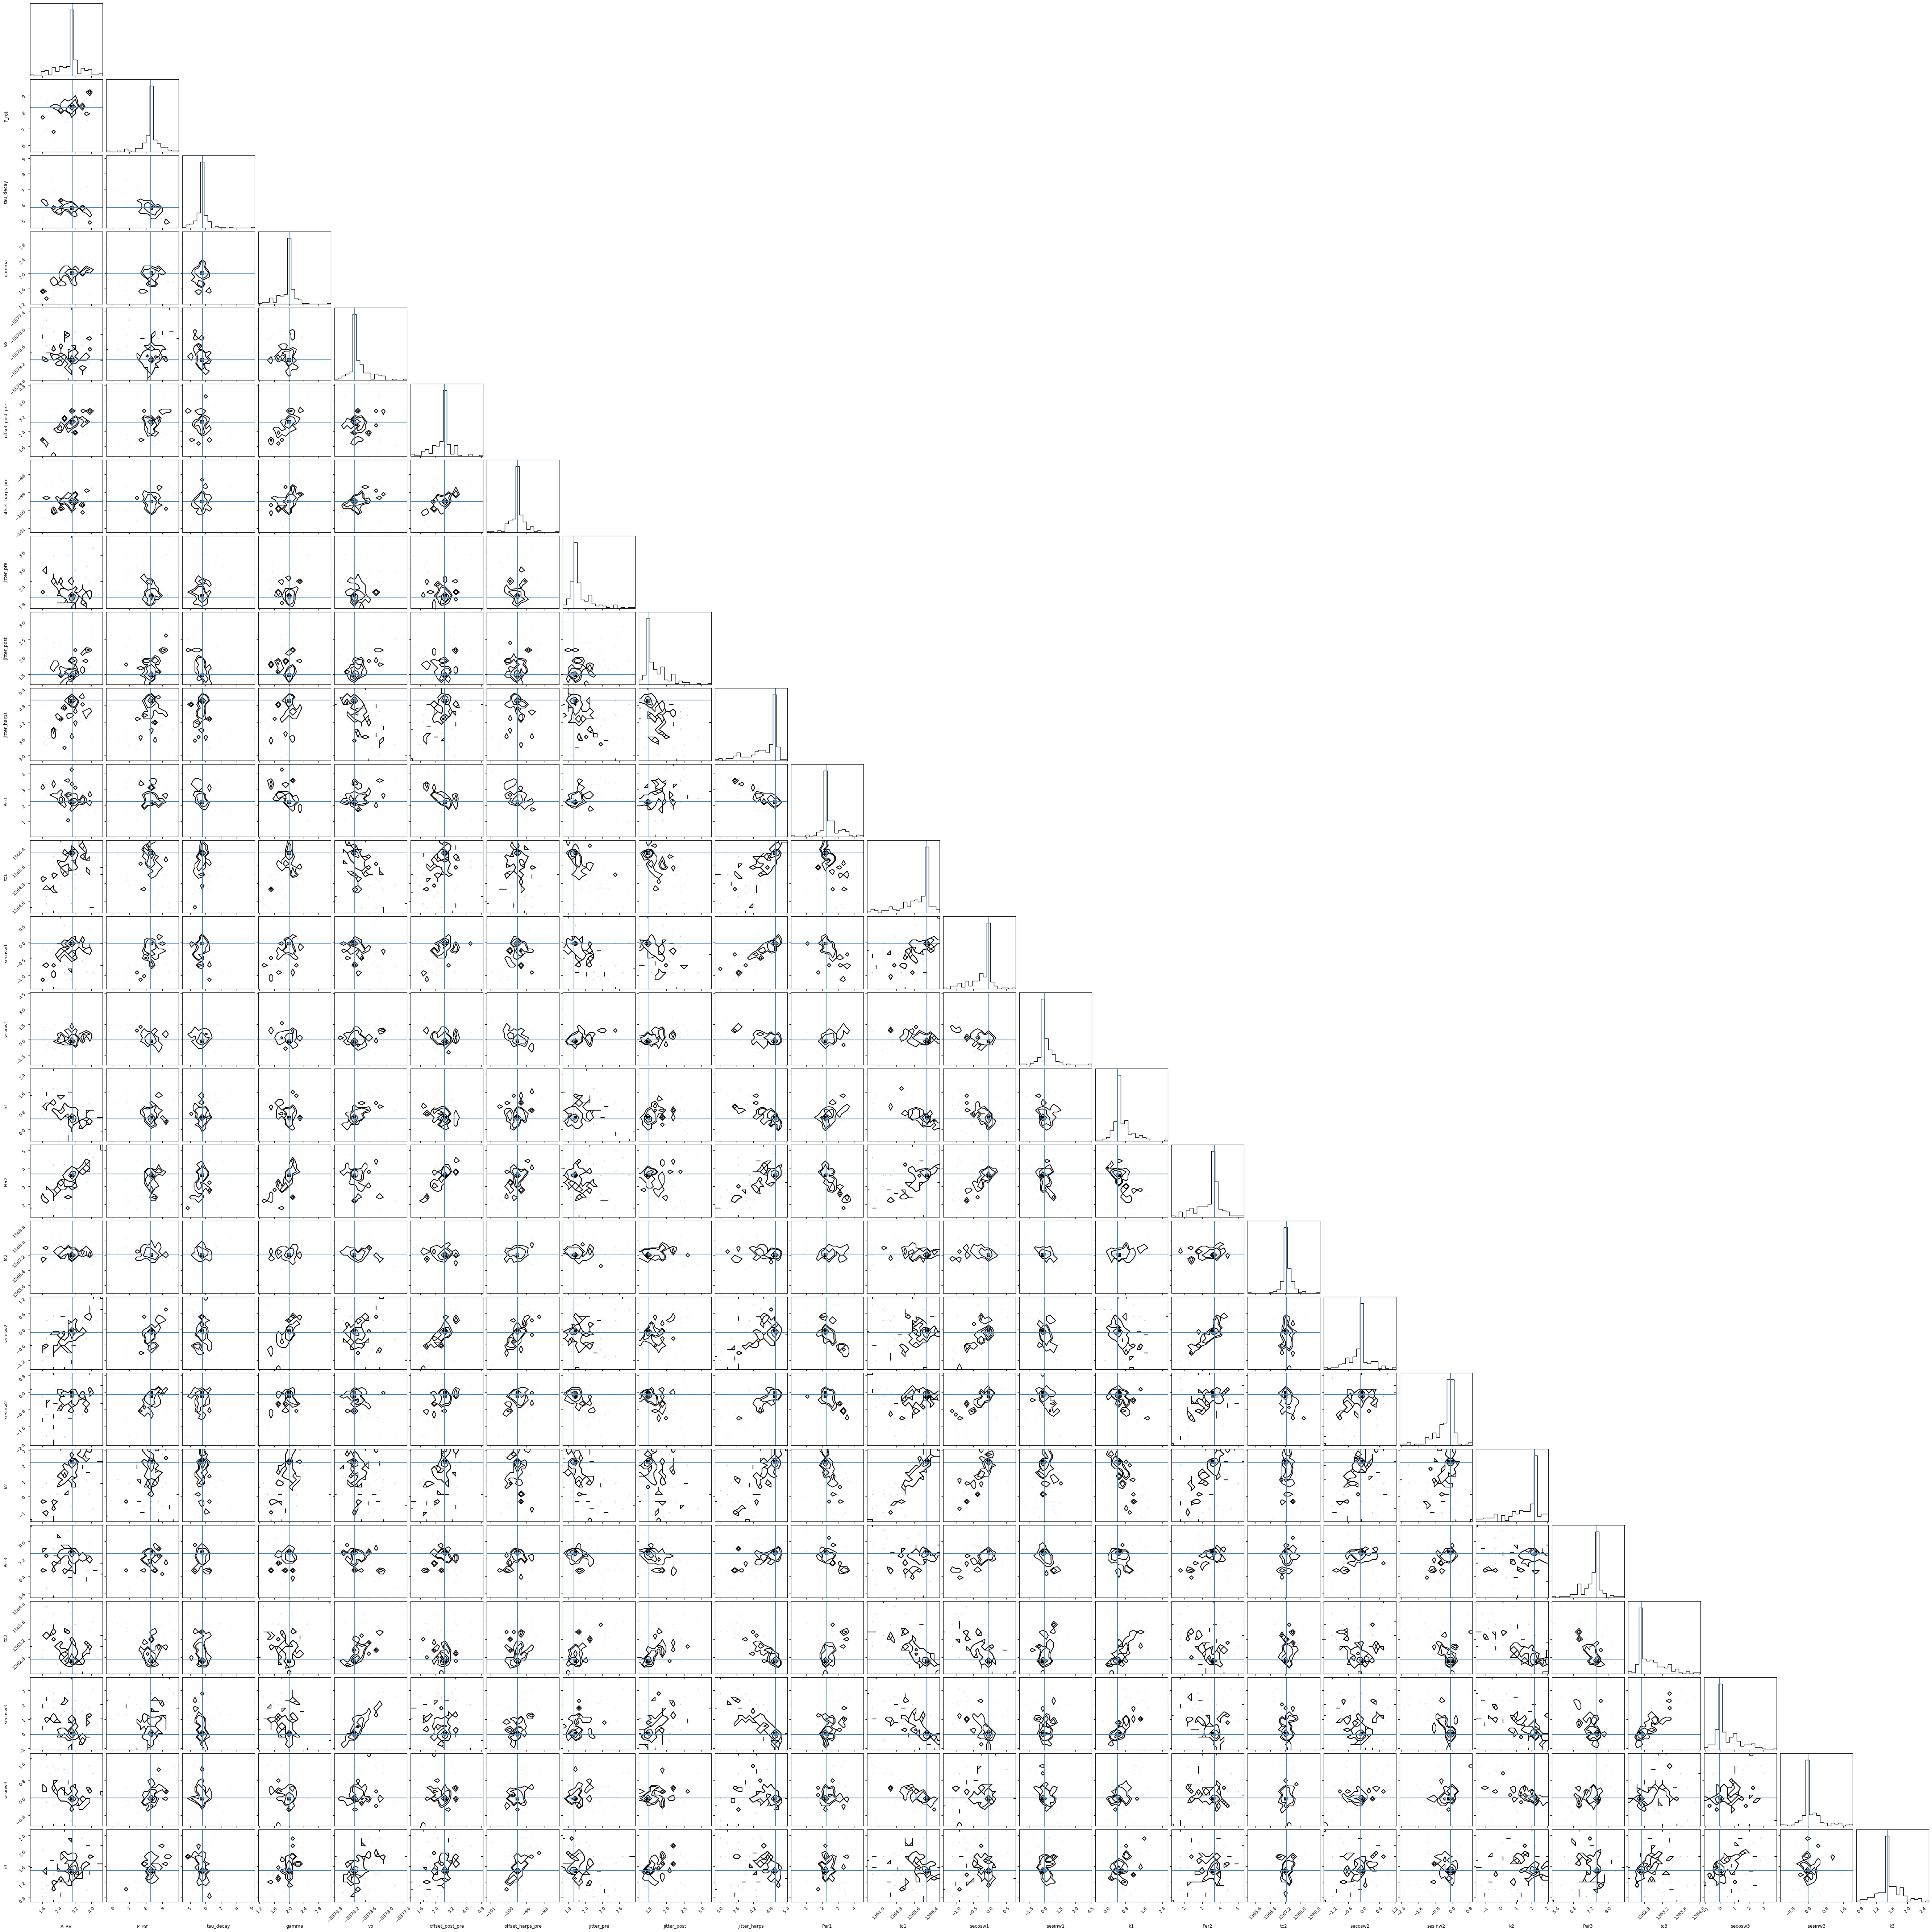

In [338]:
samples = sampler.get_chain(discard=1, thin=15, flat=True)

# GP mean
gp_mean = np.mean(samples, axis=0)
print("Mean GP parameters: ")
print("A_RV: ", gp_mean[0])
print("P_rot: ", gp_mean[1])
print("tau_decay: ", gp_mean[2])
print("gamma: ", gp_mean[3])
print("v0: ", gp_mean[4])
print("offset_post_pre: ", gp_mean[5])
print("offset_harps_pre: ", gp_mean[6])
print("jitter_pre: ", gp_mean[7])
print("jitter_post: ", gp_mean[8])
print("jitter_harps: ", gp_mean[9])
print("Per1: ", gp_mean[10])
print("tc1: ", gp_mean[11])
print("secosw1: ", gp_mean[12])
print("sesinw1: ", gp_mean[13])
print("k1: ", gp_mean[14])
print("Per2: ", gp_mean[15])
print("tc2: ", gp_mean[16])
print("secosw2: ", gp_mean[17])
print("sesinw2: ", gp_mean[18])
print("k2: ", gp_mean[19])
print("Per3: ", gp_mean[20])
print("tc3: ", gp_mean[21])
print("secosw3: ", gp_mean[22])
print("sesinw3: ", gp_mean[23])
print("k3: ", gp_mean[24])

labels=['A_RV', 'P_rot', 'tau_decay', 'gamma', 'vo', 'offset_post_pre', 'offset_harps_pre', 'jitter_pre', 'jitter_post', 'jitter_harps', 'Per1', 'tc1', 'secosw1', 'sesinw1', 'k1', 'Per2', 'tc2', 'secosw2', 'sesinw2', 'k2', 'Per3', 'tc3', 'secosw3', 'sesinw3', 'k3']

figure = corner.corner(samples, labels=labels, truths=params)

### Visual Inspection

In [217]:
time_pred = np.linspace(min(time_harps), max(time_post), 1000)

# plot
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>